In [1]:
import numpy as np
from neural_network.layer import *
from neural_network.net import *
from queue import Queue
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_network.trainutils import Dataset, train_test_split
import os

In [3]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")
dataset = Dataset(face_dir)

In [4]:
dataset.data.shape

(624, 30, 32)

In [5]:
train, validation, test = train_test_split(dataset, (0.8, 0.0, 0.2))

In [6]:
dataset[500]

(array([ 78,  59,  75,  77,  69,  67,  65,  62,  59,  56,  52,  49,  46,
         42,  41,  38,  36,  42,  31,  39,  36,  33,  39,  39,  41,  42,
         46,  46,  49,  52,  54,  56,  49,   7,  34,  44,  28,  67,  64,
         60,  59,  57,  54,  51,  49,  44,  42,  39,  39,  46,  36,  42,
         39,  36,  41,  42,  44,  46,  47,  49,  51,  54,  56,  56,  59,
          7,  26,  38,   7,  56,  62,  60,  59,  57,  54,  52,  49,  47,
         44,  42,  41,  47,  38,  44,  42,  38,  44,  46,  46,  47,  49,
         51,  52,  54,  56,  57,  42,  41,  49,  44,  28,  59,  62,  60,
         59,  57,  56,  52,  51,  49,  46,  44,  44,  47,  39,  42,  44,
         41,  47,  47,  49,  51,  51,  52,  56,  57,  56,  57,  44,  38,
         44,  41,  34,  39,  46,  52,  60,  57,  56,  54,  52,  51,  47,
         41,  21,  13,  10,  16,  20,  26,  41,  49,  51,  52,  54,  54,
         56,  57,  57,  57,  38,  10,  36,  72,  64,  62,  60,  39,  60,
         67,  64,  57,  54,  57,  31,  18,   7,   8

In [7]:
input_shape = train[0][0].shape[0]
input_shape

960

In [8]:
train[0]

(array([ 1.61946720e-01, -2.44409930e-01, -7.74316491e-01, -9.31632133e-01,
        -8.32265896e-01, -9.54374763e-01, -1.11846419e+00, -1.18376015e+00,
        -9.12663107e-01, -8.53033083e-01, -8.10587771e-01, -1.05015827e+00,
        -7.75663868e-01, -8.92452850e-01, -5.96677134e-01, -8.69459503e-01,
        -1.05380900e+00, -9.57178999e-01, -7.54239230e-01, -7.06780709e-01,
        -8.26694542e-01, -9.58123521e-01, -8.04099635e-01, -7.92006123e-01,
        -8.16026635e-01, -5.58906786e-01, -5.12507050e-01, -4.18740642e-01,
        -3.74734319e-01, -4.46618727e-01, -4.86676377e-01, -3.89681335e-01,
         8.98373138e-02, -2.99632590e-01, -2.96796478e-01, -5.05246248e-01,
        -9.45218231e-01, -9.63517786e-01, -8.77227902e-01, -9.69123485e-01,
        -9.05823856e-01, -1.04696081e+00, -1.07392244e+00, -9.13192366e-01,
        -8.03864989e-01, -9.49319532e-01, -5.22731879e-01, -7.65010839e-01,
        -1.19357327e+00, -1.31046148e+00, -7.45457669e-01, -7.81647118e-01,
        -7.7

In [9]:
linear1 = Linear(input_shape, input_shape//2)
relu1 = ReLU(linear1)
linear2 = Linear(input_shape//2, input_shape//4, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(input_shape//4, input_shape//8, relu2)
relu3 = ReLU(linear3)
linear4 = Linear(input_shape//8, input_shape//16, relu3)
relu4 = ReLU(linear4)
linear5 = Linear(input_shape//16, len(dataset.keys), relu4)
softmaxlayer = Softmax(linear5)
loss_layer = CrossEntropy(softmaxlayer)

model = NeuralNetwork(linear1, softmaxlayer, loss_layer)

In [10]:
print(model.n_layers)
print(model.output_layer)

print("Forward order:")
for layer in model._forward_order:
    print(layer)

print("\nBackward order:")
for layer in model._backward_order:
    print(layer)

11
Forward order:
Linear: (960, 1) -> (480, 1)
ReLU
Linear: (480, 1) -> (240, 1)
ReLU
Linear: (240, 1) -> (120, 1)
ReLU
Linear: (120, 1) -> (60, 1)
ReLU
Linear: (60, 1) -> (4, 1)
Softmax
CrossEntropy

Backward order:
CrossEntropy
Softmax
Linear: (60, 1) -> (4, 1)
ReLU
Linear: (120, 1) -> (60, 1)
ReLU
Linear: (240, 1) -> (120, 1)
ReLU
Linear: (480, 1) -> (240, 1)
ReLU
Linear: (960, 1) -> (480, 1)


In [12]:
loss_array = []
pbar = tqdm(range(50))
for i in pbar:
    epoch_loss = 0
    for data, label in train:
        data = data.reshape(-1, 1)
        out = model.forward(data)
        #print(out)
        loss = model.loss_layer.forward(out, label)
        epoch_loss += loss
        model.backward()
        model.step()
    epoch_loss = epoch_loss / len(train)
    loss_array.append(epoch_loss)
    pbar.set_description(str(epoch_loss))

[0.00045561]: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


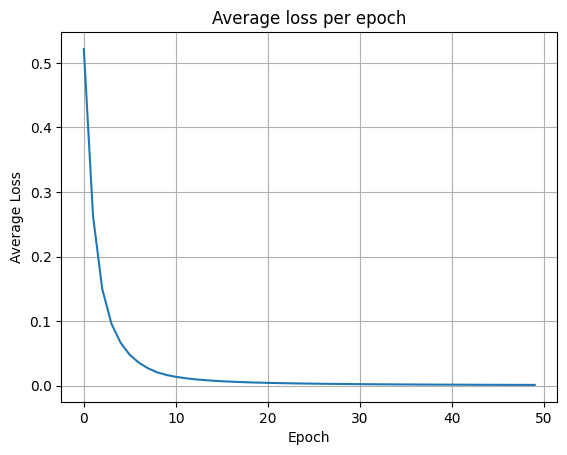

In [23]:
plt.plot(loss_array[:50])
plt.title("Average loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid()

In [16]:
unique, counts = np.unique(dataset.label, return_counts=True)

In [21]:
print(dataset.keys[unique])
print(counts)

['left' 'right' 'straight' 'up']
[157 155 156 156]


In [44]:
from PIL import Image
my_img = Image.open("test/woman_straight.jpg").convert("L")
my_img = np.array(my_img).reshape(-1, 1)
my_img.shape

(960, 1)

In [45]:
model.forward(my_img)

array([[1.00000000e+000],
       [1.01919656e-064],
       [9.57994512e-225],
       [4.93289541e-060]])